In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import fiona
import geopandas as gpd

from sklearn.manifold import TSNE

In [2]:
STREET_SHAPE_FOLDER = '/home/adelsondias/Downloads/newcastle_streets/'
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days/'

## Street shape

In [3]:
lines = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_streets.shp')
points = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_points.shp')

In [4]:
lines = lines[(lines['highway']!='') & (lines['highway']!='unclassified')]
lines['highway'].value_counts()[:5]

residential    7608
service        4673
footway        4599
tertiary        620
primary         565
Name: highway, dtype: int64

In [5]:
points = points[points['highway']!='']
points['highway'].value_counts()[:5]

bus_stop           2330
traffic_signals     411
crossing            328
turning_circle      169
mini_roundabout     143
Name: highway, dtype: int64

## LSOA shape

In [6]:
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

Filtering lines and points within LSOA of Newcastle Upon Tyne

In [7]:
lines = gpd.sjoin(lines, lsoa, how='inner' ,op='intersects')[lines.columns]
points = gpd.sjoin(points, lsoa, how='inner' ,op='intersects')[points.columns]

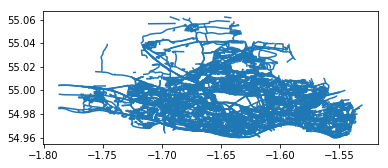

In [9]:
lines.plot()

## Sensors data

In [10]:
metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')
print(metadata.shape)
metadata.head()

(147, 5)


,type,active,lon,lat,geometry
name,,,,,
CAJT_NCA186_WR1_WR2,Traffic,True,-1.632646,54.972302,POINT (-1.63264593718199 54.97230231629401)
CAJT_NCA186_WR2_WR1,Traffic,True,-1.632801,54.972415,POINT (-1.63280112824739 54.97241510275539)
BMS_Armstrong.Armstrong;KRBlrOATTrndOATTCast (OAT Castle Leazes Trend_MOM),Environmental,True,-1.629100,54.980600,POINT (-1.6291 54.9806)
CAJT_NCA186_WR2_WR1_BUS,Traffic,True,-1.632801,54.972415,POINT (-1.63280112824739 54.97241510275539)
CAJT_NCA186_WR1_WR2_BUS,Traffic,True,-1.632646,54.972302,POINT (-1.63264593718199 54.97230231629401)


In [53]:
def spatial_features(lines, points, metadata, distance):
    l = ['cycleway','primary','secondary','service','footway','residential']
    p = ['traffic_signals','bus_stop','crossing']

    lines = lines[lines['highway'].isin(l)]
    points = points[points['highway'].isin(p)]

    ldf = pd.DataFrame(columns=l)
    pdf = pd.DataFrame(columns=p)

    for m in range(metadata.shape[0]):
        i = metadata.iloc[m]

        # distance of 0.0011 = 100m radius
        lfeatures = lines[lines['geometry'].apply(lambda x: x.distance(i['geometry']))<distance]['highway'].value_counts().reindex(lines['highway'].unique(), fill_value=0)
        ldf.loc[i.name] = lfeatures[l]

        pfeatures = points[points['geometry'].apply(lambda x: x.distance(i['geometry']))<distance]['highway'].value_counts().reindex(points['highway'].unique(), fill_value=0)
        pdf.loc[i.name] = pfeatures[p]
    return pd.concat([ldf,pdf],axis=1)
if False:
    spatial_features(lines, points, metadata, 0.0011).to_csv(DATA_FOLDER+'street_features_newcastle.csv')

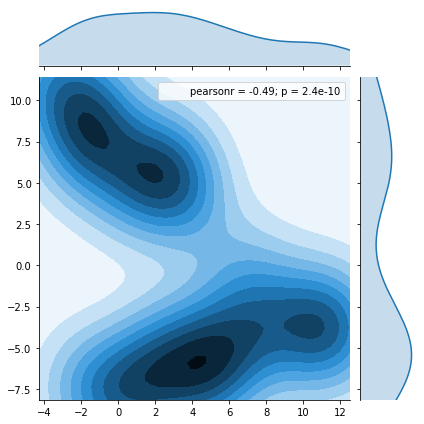

In [48]:
s1km = spatial_features(lines, points, metadata, 0.011)

#1km
tsne = TSNE(n_components=2).fit_transform(sfeat)
sns.jointplot(x=tsne[:,0], y=tsne[:,1], kind="kde", xlim=[tsne[:,0].min(),tsne[:,0].max()], ylim=[tsne[:,1].min(),tsne[:,1].max()] )

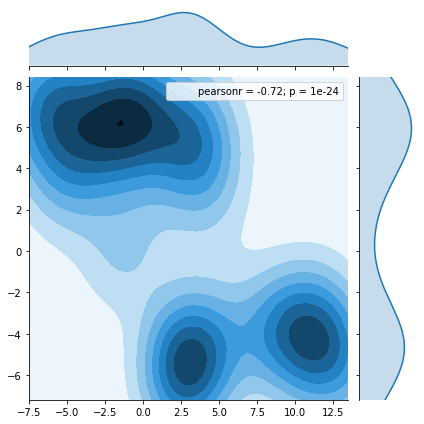

In [50]:
s500m = spatial_features(lines, points, metadata, 0.0055)
#500m
tsne = TSNE(n_components=2).fit_transform(s500m)
sns.jointplot(x=tsne[:,0], y=tsne[:,1], kind="kde", xlim=[tsne[:,0].min(),tsne[:,0].max()], ylim=[tsne[:,1].min(),tsne[:,1].max()] )

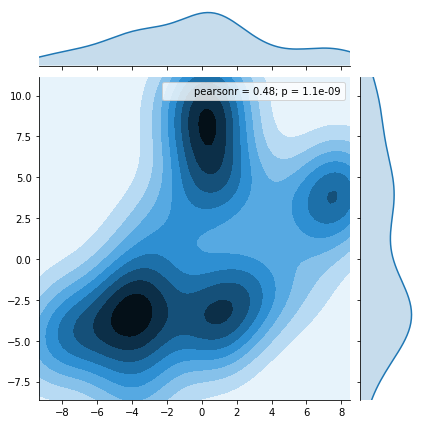

In [51]:
s100m = spatial_features(lines, points, metadata, 0.0011)
#100m
tsne = TSNE(n_components=2).fit_transform(s100m)
sns.jointplot(x=tsne[:,0], y=tsne[:,1], kind="kde", xlim=[tsne[:,0].min(),tsne[:,0].max()], ylim=[tsne[:,1].min(),tsne[:,1].max()] )

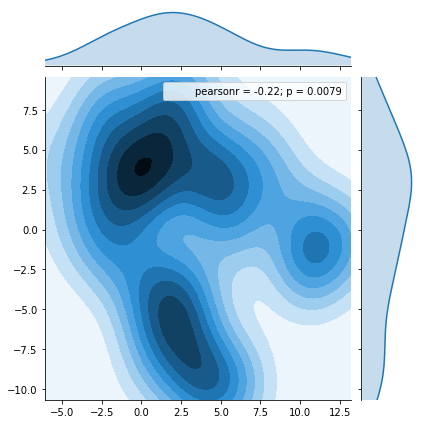

In [52]:
s50m = spatial_features(lines, points, metadata, 0.00055)
#50m
tsne = TSNE(n_components=2).fit_transform(s50m)
sns.jointplot(x=tsne[:,0], y=tsne[:,1], kind="kde", xlim=[tsne[:,0].min(),tsne[:,0].max()], ylim=[tsne[:,1].min(),tsne[:,1].max()] )

In [ ]:
# TODO: 
#   1. Label sensors with "high polution" and "low polution" class and plot street 
#      features distribution considering hue for these classes to see if there is 
#      clear separation or if not how can it be achieved to get better features